<a href="https://colab.research.google.com/github/ciepielajan/Multi-Class-Classification-NLP/blob/main/MLP_clean_lemma_glove.6B.100d" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MLP_clean_lemma_glove.6B.100d

#### Pobranie danych

In [ ]:
# https://drive.google.com/file/d/1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq/view?usp=sharing
!gdown --id "1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq"

Downloading...
From: https://drive.google.com/uc?id=1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq
To: /content/user_intent.zip
100% 271k/271k [00:00<00:00, 39.4MB/s]


In [ ]:
!unzip "user_intent.zip"

Archive:  user_intent.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
  inflating: validation.csv          


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

data_set_train = pd.read_csv("train.csv")
data_set_valid = pd.read_csv("validation.csv")

print(data_set_train.shape)
print(data_set_valid.shape)

print(data_set_train.columns)
print(data_set_valid.columns)

(13784, 2)
(700, 2)
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


#### Podstawowy process text

In [ ]:
import re
def process_text(sentence):
    sentence = re.sub('[A-Za-z0-9]+@[a-zA-z].[a-zA-Z]+', '', sentence)  # maile
    sentence = re.sub('(http[s]*:[/][/])[a-zA-Z0-9]+', '', sentence)  # linki
    sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   
    sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters

    sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE))  # Remove ONLY DUPLICATE spaces:
    sentence = sentence.lower()
    
    return sentence

In [ ]:
data_set_train["clean_text"] = data_set_train["text"].apply(lambda x: process_text(x))

#### `SpaCy` `Lemmatyzacja` 

In [ ]:
import spacy

# załadowanie angielskiego CORE 
nlp = spacy.load('en_core_web_sm')

In [ ]:
spacy.__version__

'2.2.4'

In [ ]:
%%time
data_set_train["tokens_lemma"] = data_set_train["clean_text"].apply(lambda x: " ".join([str(i.lemma_ ) for i in nlp(x) if i.lemma_  != "-PRON-"  ]))

CPU times: user 1min 50s, sys: 247 ms, total: 1min 50s
Wall time: 1min 50s


In [ ]:
data_set_train.sample(5)

text  ...                                       tokens_lemma
3872                  Play Stevan Faddy on Google Music.  ...                  play stevan faddy on google music
12934  Please play something that's freak folk on Goo...  ...  please play something that s freak folk on goo...
13113                          play a good 1952 symphony  ...                                 play good symphony
7890          give 1 out of 6 points to Revolution World  ...              give out of point to revolution world
6007   Tell me the weather forecast for Northern Mari...  ...  tell the weather forecast for northern mariana...

[5 rows x 4 columns]

In [ ]:
id_intention = 6
print("Surowy tekst")
print(data_set_train["text"].iloc[id_intention])
print("Po oczyszczeniu")
print(data_set_train["clean_text"].iloc[id_intention])
print("Po lematyzacji")
print(data_set_train["tokens_lemma"].iloc[id_intention])

Surowy tekst
Book a table for 10 people at a restaurant which offers internet.
Po oczyszczeniu
book table for people at restaurant which offers internet
Po lematyzacji
book table for people at restaurant which offer internet


#### `LabelEncoder` oraz `to_categorical`

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 


labelencoder = LabelEncoder()
data_set_train["labelencoder"] = labelencoder.fit_transform(data_set_train["label"])

dummy_y = to_categorical(data_set_train["labelencoder"], dtype ="float32")

data_set_train[["clean_text","label","labelencoder"]].head(5)

clean_text  ... labelencoder
0                      find cinema nearest for films  ...            6
1                  give the current series two stars  ...            4
2                  find the good girl at movie house  ...            6
3  please make reservations for three at kosher t...  ...            1
4  what is the forecast for here one second from now  ...            2

[5 rows x 3 columns]

In [ ]:
dummy_y.shape

(13784, 7)

In [ ]:
id_intention = 6
print("Sprawdzenie poprawności LabelEncoder i to_categorical \n")
print("Label - ", data_set_train["label"].iloc[id_intention])
print("LabelEncoder - ", data_set_train["labelencoder"].iloc[id_intention])
print()
print("to_categorical - ", dummy_y[id_intention])
print()
print("return to LabelEncoder - ",np.argmax(dummy_y[id_intention], axis=-1))
print("return to Label - ",labelencoder.inverse_transform([np.argmax(dummy_y[id_intention], axis=-1)]))

Sprawdzenie poprawności LabelEncoder i to_categorical 

Label -  BookRestaurant
LabelEncoder -  1

to_categorical -  [0. 1. 0. 0. 0. 0. 0.]

return to LabelEncoder -  1
return to Label -  ['BookRestaurant']


#### Zdefiniowanie X i y

In [ ]:
X = data_set_train["tokens_lemma"]
y = dummy_y

In [ ]:
X.shape, y.shape

((13784,), (13784, 7))

#### Podział zbioru 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11027,), (2757,), (11027, 7), (2757, 7))

#### `Tokenizer` i `pad_sequences`

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 13
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)

#### Pobranie Glove

In [ ]:
!gdown "http://nlp.stanford.edu/data/glove.6B.zip"

Downloading...
From: http://nlp.stanford.edu/data/glove.6B.zip
To: /content/glove.6B.zip
100% 862M/862M [02:41<00:00, 5.35MB/s]


In [ ]:
!unzip "glove.6B.zip"

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!head -10 "glove.6B.100d.txt"

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158 

#### Utworzenie Embedding matrix

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix('glove.6B.100d.txt', tokenizer.word_index, embedding_dim) # glove.twitter.27B.100d

#### Model

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers.embeddings import Embedding
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100,  # 100 to ilość vectorów. wiec jak importujemy zewnętrzny embedning to trzeba tą wartośc dać na vektory z zew.embedingu
                           weights=[embedding_matrix], 
                           input_length=maxlen))
model.add(Flatten())
model.add(Dense(7, activation="softmax")) # sigmoid / softmax
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 100)           976800    
_________________________________________________________________
flatten (Flatten)            (None, 1300)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 9107      
Total params: 985,907
Trainable params: 985,907
Non-trainable params: 0
_________________________________________________________________
None


> przy zew. embeddingu  zwiększyłem liczbą epok z 20 na 30, ponieważ model przy 20 epoce nadal poprawiał wydajność. W razie problemów EarlyStop przerwie trening modelu wcześniej. 

> for outsite Embedding  I increaced the number of epochs from 20 to 30, as model in epoch 20 continued to improve perfonmance. In case of deterioration of the results, the EarlyStop will stop training model earlier. 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, 
                    y_train, 
                    epochs=30,   # 20
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks = [EarlyStop] )
scores = model.evaluate(X_test, y_test)
print(f"Accuracy {scores[1] * 100}")

Epoch 1/30
138/138 [==============================] - 3s 16ms/step - loss: 1.1959 - accuracy: 0.6162 - val_loss: 0.3074 - val_accuracy: 0.9370
Epoch 2/30
138/138 [==============================] - 2s 12ms/step - loss: 0.2274 - accuracy: 0.9574 - val_loss: 0.1697 - val_accuracy: 0.9587
Epoch 3/30
138/138 [==============================] - 2s 13ms/step - loss: 0.1151 - accuracy: 0.9786 - val_loss: 0.1272 - val_accuracy: 0.9674
Epoch 4/30
138/138 [==============================] - 2s 13ms/step - loss: 0.0730 - accuracy: 0.9873 - val_loss: 0.1059 - val_accuracy: 0.9723
Epoch 5/30
138/138 [==============================] - 2s 13ms/step - loss: 0.0513 - accuracy: 0.9924 - val_loss: 0.0959 - val_accuracy: 0.9719
Epoch 6/30
138/138 [==============================] - 2s 13ms/step - loss: 0.0425 - accuracy: 0.9919 - val_loss: 0.0876 - val_accuracy: 0.9755
Epoch 7/30
138/138 [==============================] - 2s 13ms/step - loss: 0.0283 - accuracy: 0.9957 - val_loss: 0.0822 - val_accuracy: 0.9769

#### Predykcja na zbiorze validacyjnym

In [ ]:
# oczysczenie danych
data_set_valid["clean_text"] = data_set_valid["text"].apply(lambda x: process_text(x))

# labelencoder 
data_set_valid["labelencoder"] = labelencoder.fit_transform(data_set_valid["label"])

# tokenizacja weg przetrenowanego już tokenizera
X_validate = tokenizer.texts_to_sequences(data_set_valid["clean_text"])

# pad sequel
X_validate = pad_sequences(X_validate, padding="post", truncating="post", maxlen=maxlen)
X_validate

array([[ 15,  42,  50, ...,   0,   0,   0],
       [241, 177,  21, ...,   0,   0,   0],
       [ 15,   8,   1, ...,   2, 174, 997],
       ...,
       [ 28,   1,  84, ...,   0,   0,   0],
       [ 15,   8,   1, ...,   0,   0,   0],
       [ 45,  40,   4, ...,   0,   0,   0]], dtype=int32)

In [ ]:
dummy_y_valid = data_set_valid["labelencoder"].values
dummy_y_valid[:5]

array([6, 3, 2, 0, 6])

In [ ]:
# Sprawdzenie rozmiaru zbiorów validacyjnego
X_validate.shape, dummy_y_valid.shape

((700, 13), (700,))

In [ ]:
predicted_lstm_val = np.argmax(model.predict(X_validate), axis=-1)
predicted_lstm_val[:5]

array([6, 3, 2, 0, 6])

#### Rozkodowanie przewidzianych i prawidłowych etykiet

In [ ]:
y_pred = labelencoder.inverse_transform(predicted_lstm_val)
y_pred = pd.Series(y_pred)
y_pred.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

In [ ]:
y_val = labelencoder.inverse_transform(dummy_y_valid)
y_val = pd.Series(y_val)
y_val.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

#### `Confusion matrix`

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

Accuracy: 0.99
F1_score: 0.99
                      precision    recall  f1-score   support

       AddToPlaylist       0.99      1.00      1.00       100
      BookRestaurant       1.00      0.99      0.99       100
          GetWeather       0.99      1.00      1.00       100
           PlayMusic       0.99      0.98      0.98       100
            RateBook       1.00      0.99      0.99       100
  SearchCreativeWork       0.94      0.99      0.97       100
SearchScreeningEvent       0.99      0.95      0.97       100

            accuracy                           0.99       700
           macro avg       0.99      0.99      0.99       700
        weighted avg       0.99      0.99      0.99       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

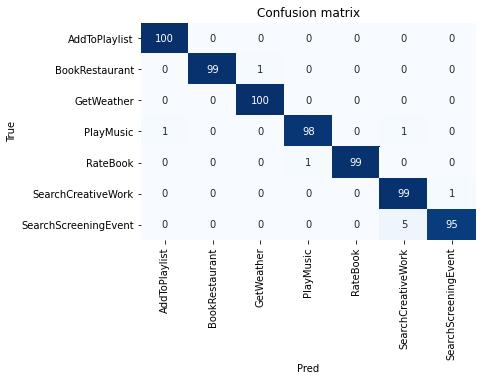

In [ ]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, y_pred),2))
print('F1_score:', round(f1_score(y_val, y_pred, average='weighted'),2))

print(classification_report(y_val, y_pred))
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#### Zapoznanie się z błędnymi predykcjami 

In [ ]:
indexes = []
for i, phrase in enumerate(y_pred):
  if phrase == 'SearchCreativeWork':
    if y_val[i] == 'SearchScreeningEvent':
      indexes.append(i)
print(indexes)

[451, 519, 557, 648, 689]


In [ ]:
for i in indexes:
  print(f"----------------------------\nTekst komendy:\n{data_set_valid['text'][i]}")
  print(f"Oczyszczona komenda:\n{data_set_valid['clean_text'][i]}")
  print(f'True category: {y_val[i]}')
  print(f'Predicted category: {y_pred[i]}')
  print("\n")

----------------------------
Tekst komendy:
Can I see Ellis Island Revisited in 1 minute
Oczyszczona komenda:
can see ellis island revisited in minute
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
i want to see JLA Adventures: Trapped In Time
Oczyszczona komenda:
want to see jla adventures trapped in time
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Shattered Image.
Oczyszczona komenda:
want to see shattered image
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Outcast.
Oczyszczona komenda:
want to see outcast
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Fear Chamber.
Oczyszczona komenda:
want to see fear chamber
True category: SearchScreeningEvent
P

Wnioski:
> 